# 데이터 불러오기
- 데이터 형태는 
- X = (3950, 20)과 같이 (전체 데이터 개수, voca_size)
- y = (3950,1) 과같이 (전체 데이터 개수, 정수)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import regularizers

In [2]:
# 데이터 로드
train_data_path = "./train_general.csv"
train_data = pd.read_csv(train_data_path)

# 클래스 이름
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

# 전체 corpus와 클래스 레이블 준비
corpus = train_data["cleaned_conversation"]
labels = train_data['class']

train_data.head()

,idx,class,conversation,text_length,word_count,cleaned_conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,52,52,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,39,39,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,52,52,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,34,34,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,118,118,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


In [3]:
# 토큰화 + encoding 진행 
# 변수 = voca_size, 토큰화 방법

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=10000, 
        filters=' ',
        oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=100)  
    return tensor, tokenizer

# 토큰화 수행
tensor, tokenizer = tokenize(corpus)

In [4]:
# (데이터 개수, max_length)
tensor.shape

(4976, 100)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(tensor, labels, test_size=0.2, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [6]:
# 클래스 가중치 계산 (클래스 4 포함)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# 각 샘플에 가중치 할당
sample_weights = np.array([class_weights[y] for y in y_train])

# tf.data.Dataset으로 변환 (sample_weight 포함)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# 데이터셋을 섞고, 배치 처리
train_dataset = train_dataset.cache().shuffle(10000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(32)

# 모델

In [7]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [8]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    if mask is not None:
        logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        outputs = self.dense(concat_attention)
        return outputs

In [10]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [11]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    outputs = tf.keras.layers.Dense(units=units, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [12]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name="encoder_layer_{}".format(i))([outputs, padding_mask])
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [13]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[inputs, enc_padding_mask])
    pooled_outputs = tf.keras.layers.GlobalAveragePooling1D()(enc_outputs)
    pooled_outputs = tf.keras.layers.Dropout(rate=dropout)(pooled_outputs)
    outputs = tf.keras.layers.Dense(units=1028, activation='relu', name="linear_hidden_layer")(pooled_outputs)
    outputs = tf.keras.layers.Dense(units=5, activation='softmax', name="outputs")(outputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [14]:
VOCAB_SIZE = 10000
NUM_LAYERS = 1
D_MODEL = 512
NUM_HEADS = 8
UNITS = 256
DROPOUT = 0.4

model = transformer(vocab_size=VOCAB_SIZE, 
                    num_layers=NUM_LAYERS, 
                    units=UNITS, 
                    d_model=D_MODEL, 
                    num_heads=NUM_HEADS, 
                    dropout=DROPOUT)
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    6435584     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 512)          0           encoder[0][0]          

In [15]:
def loss_function(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    return tf.reduce_mean(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred))

In [16]:
def accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [17]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [18]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=2, 
                               restore_best_weights=True)


In [20]:
# 모델 학습
EPOCHS = 100
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
112/112 [==============================] - 5s 23ms/step - loss: 2.0089 - accuracy: 0.2038 - val_loss: 1.9084 - val_accuracy: 0.2261
Epoch 2/100
112/112 [==============================] - 2s 20ms/step - loss: 1.8657 - accuracy: 0.3255 - val_loss: 1.6415 - val_accuracy: 0.4724
Epoch 3/100
112/112 [==============================] - 2s 20ms/step - loss: 1.5022 - accuracy: 0.5226 - val_loss: 1.1892 - val_accuracy: 0.6583
Epoch 4/100
112/112 [==============================] - 2s 20ms/step - loss: 1.2082 - accuracy: 0.6477 - val_loss: 1.1034 - val_accuracy: 0.6985
Epoch 5/100
112/112 [==============================] - 2s 21ms/step - loss: 1.0487 - accuracy: 0.7138 - val_loss: 0.9001 - val_accuracy: 0.7688
Epoch 6/100
112/112 [==============================] - 2s 21ms/step - loss: 0.8448 - accuracy: 0.7998 - val_loss: 0.8540 - val_accuracy: 0.8166
Epoch 7/100
112/112 [==============================] - 2s 21ms/step - loss: 0.6632 - accuracy: 0.8691 - val_loss: 0.8683 - val_accuracy:

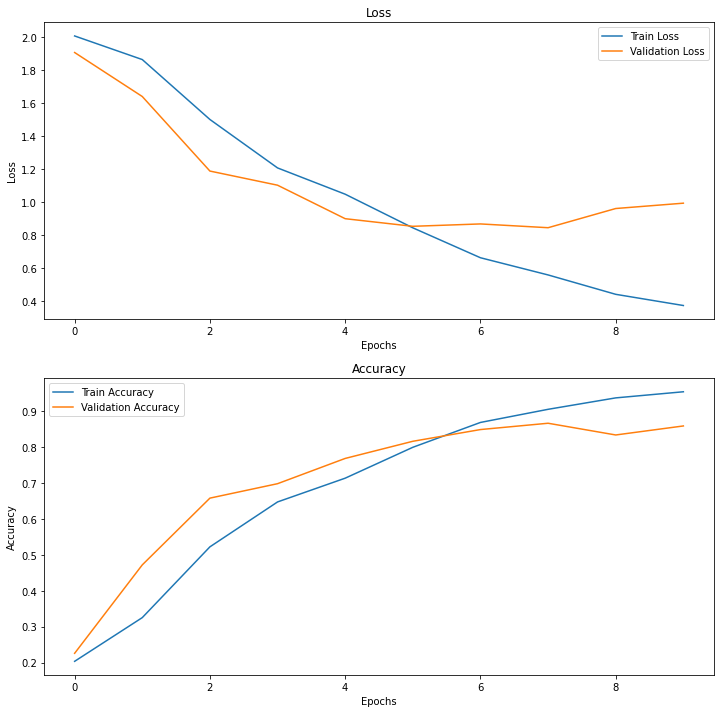

In [21]:
import matplotlib.pyplot as plt

# 정확한 val_loss 및 val_accuracy 플롯
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Train/Val Loss Plot
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Train/Val Accuracy Plot
axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [23]:
model.evaluate(val_dataset)

13/13 [==============================] - 0s 10ms/step - loss: 0.8454 - accuracy: 0.8668


[0.8454300165176392, 0.8668341636657715]

In [24]:
# 각 데이터셋의 클래스 분포를 확인
print("Train class distribution:\n", train_data['class'][:3500].value_counts())
print("Validation class distribution:\n", train_data['class'][3500:3850].value_counts())
print("Test class distribution:\n", train_data['class'][3850:].value_counts())

Train class distribution:
 3    982
1    868
2    867
0    783
Name: class, dtype: int64
Validation class distribution:
 0    97
2    91
3    83
1    79
Name: class, dtype: int64
Test class distribution:
 4    1026
1      34
3      29
2      21
0      16
Name: class, dtype: int64


# 하이퍼 파라미터 튜닝용

In [ ]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {

        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            },
        
        "drop_out" : {
            "min": 0.1,
            "max": 0.4
        }
                    
        }
    }

# Submission

In [25]:
import os
import sys
sys.path.append("../")

## 경고 무시
import warnings
warnings.filterwarnings('ignore')

## 시각화 툴
import matplotlib.pyplot as plt
import seaborn as sns

## encoding 
from sklearn.preprocessing import LabelEncoder

## vocabulary
import tensorflow_datasets as tfds

## preprocessor
from custom_preprocessor import Preprocessor

In [26]:
preprocessor = Preprocessor()

In [27]:
preprocessed_train, preprocessed_test = preprocessor.preprocess()

In [28]:
# test 데이터셋 불러와서 text 부분 tokenize 진행
text = preprocessed_test['text']
test_tensor, tokenizer = tokenize(text)

In [29]:
# 크기 확인
test_tensor.shape

(500, 100)

In [30]:
# 모델의 결과값은 5개의 클래스중 확률값을 가지고있는 상태
# 가장큰 값을 가지도록 매칭해줘야함
result_vec = model(test_tensor)
y_pred = np.argmax(result_vec, axis=1)

In [33]:
# 제출 파일 함수
import os
from os.path import join

def save_submission(y_pred, user_name, f1_score=None):
    data_path ="/aiffel/aiffel/dlthon_team5/data"
    save_path ="../submission"
    submission_path = join(data_path, 'new_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['class'] = y_pred
    submission_csv_path = '{}/submission_{}_f1score_{}.csv'.format(save_path, user_name, f1_score)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [35]:
# 뒤쪽 str값은 본인 이니셜과 버전을 작성하면됨
save_submission(y_pred,'hsv_v1', 0.8668)

../submission/submission_hsv_v1_f1score_0.8668.csv saved!
